# Classic NLP. Ternary Classification

## 1. Load Libraries

In [1]:
import re   ### for regular expressions
import string
import pickle
import bentoml
import numpy as np
import pandas as pd


import nltk ### for text preprocessing

nltk.download('stopwords')
nltk.download('punkt')
nltk.download("wordnet")
nltk.download('omw-1.4')

from nltk.corpus import stopwords ### stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer ### for stemming and lemmatization
from nltk import sent_tokenize, word_tokenize, regexp_tokenize ### for tokenization


from wordcloud import WordCloud ### for wordclouds

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer ### for vectorization
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV ### for parameter tuning in pipeline
from sklearn.metrics import roc_auc_score, f1_score, make_scorer, confusion_matrix ### for model assesment

from xgboost import XGBClassifier, DMatrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nenomius/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nenomius/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nenomius/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nenomius/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 2. Data preprocessing

### 2.1. Load dataset

In [2]:
### read the data
df_train = pd.read_csv("t1_data_train.tsv", sep='\t', index_col=0)
df_validation = pd.read_csv("t1_data_test.tsv", sep='\t', index_col=0)

In [3]:
### check data parameters
df_train.info(), df_validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22287 entries, 0 to 22287
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         22287 non-null  object
 1   class_label  22287 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 522.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10977 entries, 0 to 10978
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         10977 non-null  object
 1   class_label  10977 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 257.3+ KB


(None, None)

In [4]:
df_train.head()

,text,class_label
id,,
0,Great initiative,0
1,....This app activating ; then Blootooth all w...,1
2,I am fully supportive of this app and want it ...,0
3,Once you registered in absher you cannot regis...,1
4,The app keeps stopping. Pls fix this I'll chan...,2


### 2.2. Check Distribution of lengths in splits

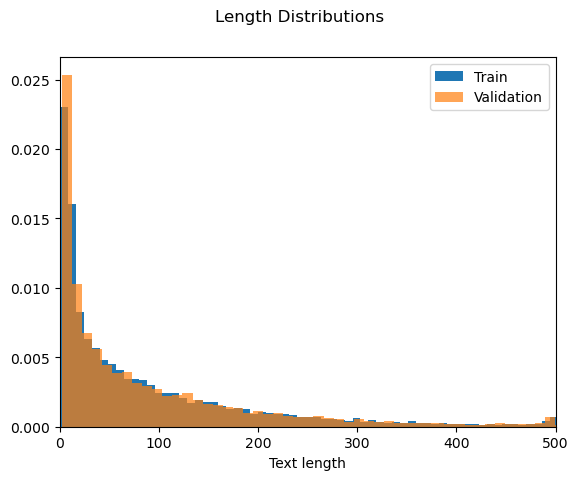

In [5]:
fig, ax = plt.subplots(1)
plt.hist(df_train.text.str.len(), bins="fd", density=True, label="Train")
plt.hist(df_validation.text.str.len(), bins="fd", density=True, alpha=0.7, label="Validation")
ax.set_xlim(0, 500)
plt.xlabel("Text length")
plt.suptitle("Length Distributions")
plt.legend()
plt.show()

### 2.3. Check Class Stratification in Data Sets

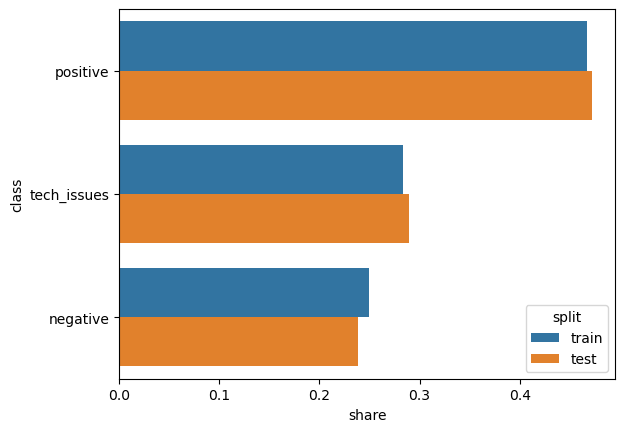

In [6]:
upper_sent = pd.concat(
    [
        (df_train.class_label.value_counts() / df_train.class_label.shape[0]).rename("share"), 
        pd.Series(
            ["train"] * len(df_train.class_label.unique()), 
            index=df_train.class_label.unique(), 
            name="split"
            )
    ], 
    axis=1
)
upper_sent["class"] = ["positive", "tech_issues", "negative"]
upper_sent.set_index("class", inplace=True)
lower_sent = pd.concat(
    [
        (df_validation.class_label.value_counts() / df_validation.shape[0]).rename("share"), 
        pd.Series(["test"] * len(df_validation.class_label.unique()), 
        index=df_validation.class_label.unique(), 
        name="split"
        )
    ], 
    axis=1
)
lower_sent["class"] = ["positive", "tech_issues", "negative"]
lower_sent.set_index("class", inplace=True)
sentiment_distribution = pd.concat([upper_sent, lower_sent])
sns.barplot(
    data=sentiment_distribution, 
    x=sentiment_distribution.share, 
    y=sentiment_distribution.index, 
    hue="split"
)
plt.show()

### 2.4. Prepare Custom Tokenizer with combined Stemmer and Lemmatizer

In [7]:
### list of filtered stopwords
stop_words = stopwords.words("english")
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [8]:
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer(language="english")

# combined Lemmatizer & Stemmer for text normalization
def normalize_tokens(tokens):
    stem_text = [stemmer.stem(i) for i in tokens]
    lem_text = [lemmatizer.lemmatize(i) for i in stem_text]
    return lem_text

def remove_stopwords(tokens, stopwords=None, min_length=2):
    if not stopwords:
        return tokens
    stopwords = set(stopwords)
    tokens = [tok
              for tok in tokens
              if tok not in stopwords and len(tok) >= min_length]
    return tokens

### Create tokenizer for our TfidfVectorizer, using functions above

# default regexp in TfidfVectorizer
# r"(?u)\b\w\w+\b"

def tokenize_n_lemmatize(
    text, stopwords=stop_words, normalize=True,
    regexp = r"(?u)\b\w\w+\b"):
    words = [w for sent in sent_tokenize(text)
             for w in regexp_tokenize(sent, regexp)]
    if normalize:
        words = normalize_tokens(words)
    if stopwords:
        words = remove_stopwords(words, stopwords=stopwords)
    return words

In [9]:
#### Show example of tokenize_n_lemmatize
print(df_train.text[67])
tokenize_n_lemmatize(df_train.text[67])

Used only 2% battery in 24 hours. Good privacy model in only locally storing the information and you having to manual upload the deidentified data if you test positive.


['use',
 'onli',
 'batteri',
 '24',
 'hour',
 'good',
 'privaci',
 'model',
 'onli',
 'local',
 'store',
 'inform',
 'manual',
 'upload',
 'deidentifi',
 'data',
 'test',
 'posit']

### 2.5. Check Created Tokens with Clouds of Words for three classes

In [10]:
#### normalize our text for word cloud creation
df_train["norm_text"] = df_train.text.apply(lambda x: tokenize_n_lemmatize(x))

In [11]:
### create function for world clouds plotting
def PlotWordCloud(text, stop_words=None):
    wcd = WordCloud(
        width=800, 
        height=500, 
        background_color="black", 
        random_state=13, 
        max_font_size=110, 
        stopwords=stop_words,
        colormap='Spectral').generate_from_frequencies(text)
    plt.figure(figsize=(10, 7))
    plt.imshow(wcd, interpolation="bilinear")
    plt.axis('off')

In [12]:
### I want to drop out the common words that lay in top 20 most frequent words of each class
all_norm_words = [] ### it was used in addition to the stopwords
for i in range(3):
    normalized_words = ' '.join([' '.join(text) for text in df_train.norm_text[df_train.class_label==i]])
    all_norm_words.append(set(pd.Series(normalized_words.split(' ')).value_counts()[:20].index))

In [13]:
add_stop = list(all_norm_words[0].intersection(all_norm_words[1], all_norm_words[2]))

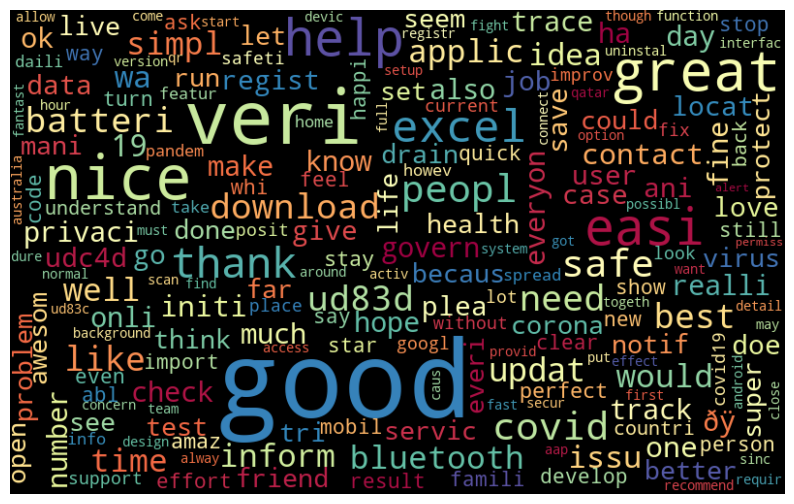

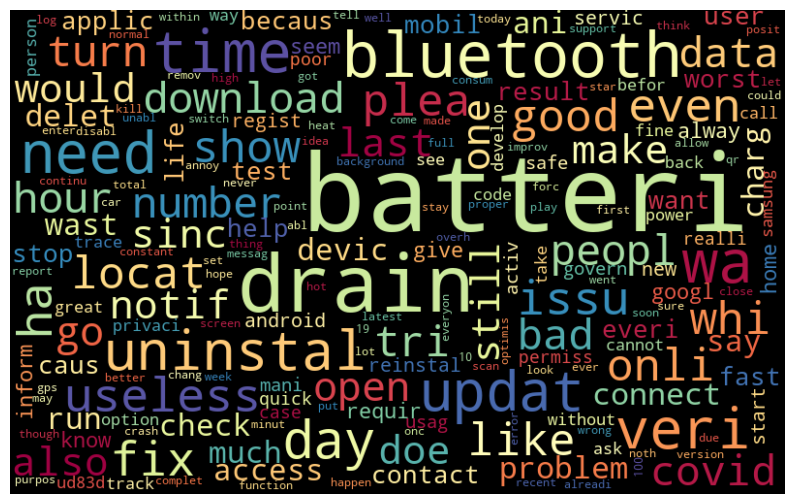

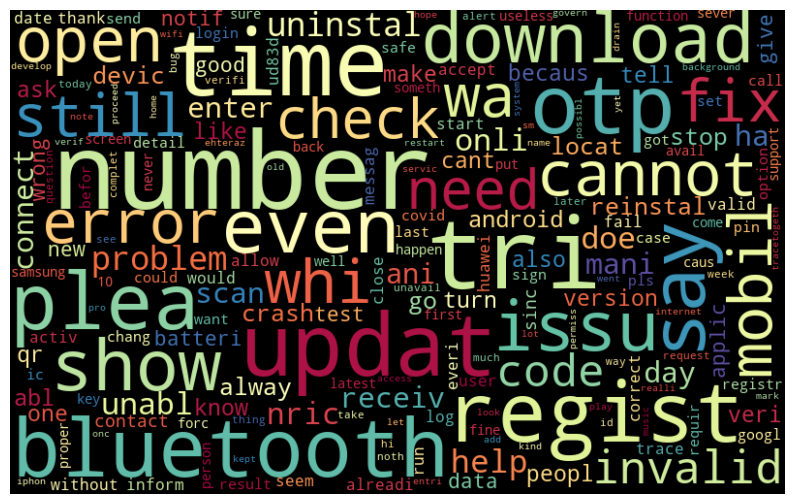

In [14]:
#### Finally let's plot word clouds
for i in range(3):
    normalized_words = ' '.join([' '.join(text) for text in df_train.norm_text[df_train.class_label==i]])
    normalized_words = pd.Series([i for i in normalized_words.split(' ') if i not in stop_words+add_stop]).value_counts()
    PlotWordCloud(normalized_words, stop_words=stop_words+add_stop)

### 2.6 TfidfVectorizer for vectorzation

In [15]:
### use custom tokenizer with vectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenize_n_lemmatize, min_df=5, ngram_range=(1,3))
vectorizer.fit(df_train.text)

/home/nenomius/miniconda3/envs/nlp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(min_df=5, ngram_range=(1, 3),
                tokenizer=<function tokenize_n_lemmatize at 0x7f6d5619b520>)

In [16]:
X_vectorized = vectorizer.transform(df_train.text)
feature_names = np.array(vectorizer.get_feature_names_out())

In [17]:
### it's possible to extact n-grams with highest (lowest) tf-idf index
sorted_tfidf_index = X_vectorized.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['time dure night' 'exposur ha' 'day guess app' 'per day guess'
 'provid jef neef' 'exposur check bluetooth' 'impact promis'
 'impact promis alert' 'around check time' 'around check']

Largest tfidf: 
['onli' 'look' 'chine' 'problem' 'track' 'log' 'perfect' 'gd' 'dumb'
 'awesom']


In [18]:
### Let's find dependency between minimum token frequency and vocabulary size
min_df_list = np.linspace(1, 3500, 100).astype(int)
max_features_list = []
for i in min_df_list:
    max_features_list.append(
        (pd.Series(vectorizer.vocabulary_) >= i).sum()
    )

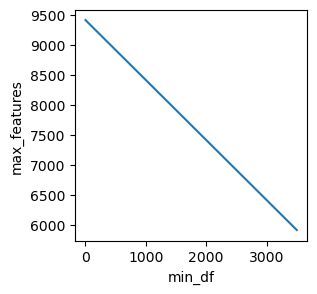

In [19]:
### Just linear dependency
plt.figure(figsize=(3, 3))
plt.plot(min_df_list, max_features_list)
plt.xlabel("min_df")
plt.ylabel("max_features")
plt.show()

## 3. Parameter's Tuning with GridsearchCV

### 3.1. Logistic Regression Pipeline

In [20]:
#### We definetely don't want to run this part each time, use pickle instead

In [21]:
cv = RepeatedStratifiedKFold(n_repeats=4, n_splits=5)
vectorizer = TfidfVectorizer(tokenizer=tokenize_n_lemmatize)
model = LogisticRegression(class_weight="balanced")
scoring = make_scorer(f1_score , average="weighted")

# create a pipeline
clf_estimators = [
    ("vec", vectorizer),
    ("model", model)
]

pipe_clf = Pipeline(clf_estimators)

### parameters grid for tuning
param_grid_clf = {
    "vec__min_df": [5, 10, 1000, 2000, 3000], #### can be used instead of max_features 
    "vec__ngram_range": [(1, 2), (1, 3)],
    "model__penalty": ["l2"],
    "model__C": [0.001, 0.01, 0.1, 1, 10],
    "model__multi_class": ["ovr"]
}

model_gscv = GridSearchCV(
    pipe_clf, 
    param_grid_clf,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)
model_gscv.fit(df_train.text, df_train.class_label)

output_file = "LogisticRegression.bin"
with open(output_file, 'wb') as f_out: 
    pickle.dump((model_gscv), f_out)

/home/nenomius/miniconda3/envs/nlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nenomius/miniconda3/envs/nlp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

### 3.2. XGBClassifier Pipeline

In [24]:
vectorizer = TfidfVectorizer(tokenizer=tokenize_n_lemmatize, min_df=5, ngram_range=(1, 3))
model_xgb = XGBClassifier()

# create a pipeline
clf_estimators = [
    ("vec", vectorizer),
    ("model", model_xgb)
]

pipe_clf = Pipeline(clf_estimators)

### parameters grid for tuning
param_grid_clf = {
    "model__max_depth": [6, 10, 15],
    "model__n_estimators": [200, 300],
    "model__min_child_weight": [1, 300, 1000],
    "model__learning_rate": [0.1, 0.3, 1],
    "model__gamma": [0, 0.01, 0.1]
}


model_gscv_xgb = GridSearchCV(
    pipe_clf, 
    param_grid_clf,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=1
)
model_gscv_xgb.fit(df_train.text, df_train.class_label)

### Save model
output_file = "XGBClassifier.bin"
with open(output_file, 'wb') as f_out: 
    pickle.dump((model_gscv_xgb), f_out)

Fitting 20 folds for each of 162 candidates, totalling 3240 fits


## 4 Models Assessment

Use weighted f1 score and weighted AUC (in ["ovr"](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest) paradigm)

In [21]:
### Load models
input_file = "LogisticRegression.bin"
with open(input_file, 'rb') as f_in: 
    LogRegPickle = pickle.load(f_in)

input_file = "XGBClassifier.bin"
with open(input_file, 'rb') as f_in: 
    XGBCPickle = pickle.load(f_in)

In [22]:
#### Create Confusion Matrix Plot Function
def ConfMatPlot(X, y, model):
    validation_labels_counts = y.value_counts().sort_index().values
    vlc = np.repeat(validation_labels_counts, 3).reshape(3,-1)
    cm = confusion_matrix(y_pred=model.predict(X), y_true=y)
    fig, ax=plt.subplots(figsize=(5, 4))
    sns.heatmap(np.round(cm/vlc, 3), annot=True, fmt='g', ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels([0, 1, 2])
    ax.yaxis.set_ticklabels([0, 1, 2])
    plt.show()

### 4.1. Logistic Regression metrics

In [23]:
f1_train = f1_score(df_train.class_label, LogRegPickle.predict(df_train.text), average="weighted").round(3)
f1_val = f1_score(df_validation.class_label, LogRegPickle.predict(df_validation.text), average="weighted").round(3)
print(f"Logistic Regression weighted f1 score - train: {f1_train}\t- validation:{f1_val}")

Logistic Regression weighted f1 score - train: 0.869	- validation:0.817


In [24]:
auc_train = roc_auc_score(df_train.class_label, LogRegPickle.predict_proba(df_train.text), average="weighted", multi_class="ovr").round(3)
auc_val = roc_auc_score(df_validation.class_label, LogRegPickle.predict_proba(df_validation.text), average="weighted", multi_class="ovr").round(3)
print(f"Logistic Regression weighted AUC (ovr) - train: {auc_train}\t- validation:{auc_val}")

Logistic Regression weighted AUC (ovr) - train: 0.968	- validation:0.943


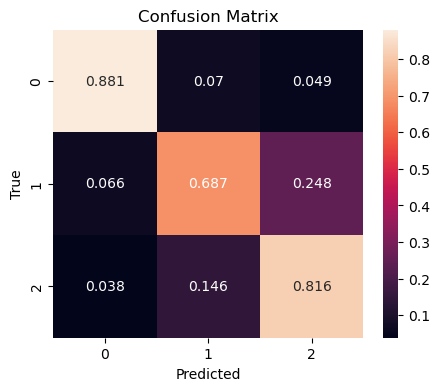

In [25]:
ConfMatPlot(df_validation.text, df_validation.class_label, LogRegPickle)

### 4.2. XGBClassifier metrics

In [26]:
f1_train = f1_score(df_train.class_label, XGBCPickle.predict(df_train.text), average="weighted").round(3)
f1_val = f1_score(df_validation.class_label, XGBCPickle.predict(df_validation.text), average="weighted").round(3)
print(f"XGBClassifier weighted f1 score - train: {f1_train}\t- validation:{f1_val}")

XGBClassifier weighted f1 score - train: 0.964	- validation:0.822


In [27]:
auc_train = roc_auc_score(df_train.class_label, XGBCPickle.predict_proba(df_train.text), average="weighted", multi_class="ovr").round(3)
auc_val = roc_auc_score(df_validation.class_label, XGBCPickle.predict_proba(df_validation.text), average="weighted", multi_class="ovr").round(3)
print(f"XGBClassifier weighted AUC (ovr) - train: {auc_train}\t- validation:{auc_val}")

XGBClassifier weighted AUC (ovr) - train: 0.995	- validation:0.944


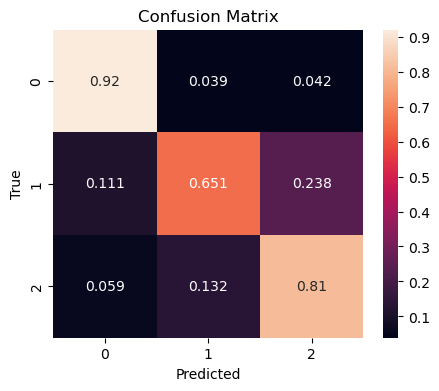

In [28]:
ConfMatPlot(df_validation.text, df_validation.class_label, XGBCPickle.best_estimator_)

## 5. BentoML for Deployment

In [29]:
print(XGBCPickle.best_params_)

{'model__gamma': 0.01, 'model__learning_rate': 0.3, 'model__max_depth': 10, 'model__min_child_weight': 1, 'model__n_estimators': 300}


### 5.1. Reconstruct model parts

In [30]:
vectorizer = TfidfVectorizer(
    tokenizer=tokenize_n_lemmatize, 
    min_df=5, 
    ngram_range=(1, 3)
)
model = XGBClassifier(
    gamma=0.01, 
    learning_rate=0.3, 
    max_depth=10, 
    min_child_weight=1, 
    n_estimators=300, 
    n_jobs=-1
)

### 5.2. Check that everything works as expected

In [31]:
X_train = vectorizer.fit_transform(df_train.text)
X_val = vectorizer.transform(df_validation.text)


In [32]:
model.fit(X_train, df_train.class_label)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.01, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [33]:
f1_score(df_validation.class_label, model.predict(X_val), average="weighted").round(3)

0.822

### 5.3. Save the model with bentoml

In [34]:
bentoml.sklearn.save_model(
    'sentiment_model',
    model,
    custom_objects={
        'vectorizer': vectorizer
    }
)

Model(tag="sentiment_model:e5udd4c7l6jmtuan", path="/home/nenomius/bentoml/models/sentiment_model/e5udd4c7l6jmtuan/")

In [35]:
### check that model was saved correctly
booster = bentoml.sklearn.load_model("sentiment_model:latest")
booster.predict(vectorizer.transform(df_validation.text.iloc[:2]))

array([2, 0])